#  Part-1 Missing Pieces and Partially-Completed Pieces

In [10]:
from PIL import Image   # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 
import matplotlib.pyplot as plt # this is for plotting (showing) images 
import cv2
from scipy.ndimage import filters

data_dir = '/Users/haritharash/Desktop/warwick/class/Image_&_Video_Analysis/coursework/data/'

puzzle_1 = np.array(Image.open(data_dir + 'missing-pieces-1.jpg').convert('RGB'))
def showpic(image, width=10):
  plt.figure(figsize=(width, width/1000*727))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def showlist(tiles, col=5,width=10):
  n_rows = np.ceil(len(tiles)/col).astype('int')
  plt.subplots(n_rows, col, figsize=(width, width))
  for i in range(len(tiles)):
    plt.subplot(n_rows, col, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(tiles[i])
  plt.show()

def getColors(img, subcontour):
  subcontour = np.flip(subcontour)
  colors = []
  for n in range(len(subcontour)-3):
    (y,x) = subcontour[n]
    (y1,x1) = subcontour[n+3]
    h, w = y1 - y, x1 - x
    new_image = img[y-w, x+h, :3] + img[y+w, x-h, :3]
    colors.append(new_image)

  colors = np.array(colors, 'uint8').reshape(-1,1,3)
  colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)
  
  return colors.reshape(-1,3)

  
def data_packaging(coordinate,center,type,contour_cut):
  locks = {}
  # take the biggest difference as  reference
  xd = abs(coordinate[0] - center[0])
  yd= abs(coordinate[1] - center[1])
  if( coordinate[0] < center[0] and xd > yd):
    locks = { 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos':'LEFT'
                    }
  elif( yd > xd and coordinate[1] > center[1]):
  # elif( coordinate[1] > 600):
    locks = { 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos': 'BOTTOM'
                  }
    
  elif( coordinate[0] > center[0] and xd > yd):
  # elif( coordinate[0] > 600):
    locks = { 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos':'RIGHT'
                    }

  elif( yd > xd  and coordinate[1] < center[1]):
    locks ={ 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos': 'TOP'
                    }
  return locks

def colour_contour_edges(coord,contour,EDGE_LENGTH=350):
    start = coord - EDGE_LENGTH
    end = coord + EDGE_LENGTH
    if( abs(end-start) >  EDGE_LENGTH*2):
      end = end -1
    contour_cut = contour[start : end]
    if end > len(contour)-1:
      contour_cut =  np.append(contour[start:],contour[:end - (len(contour))],0)
    elif start < 0:
      contour_cut = np.append(contour[start:],contour[:end],0)
    return contour_cut

def inner_out_lock_orientations(contour,defect_indices,center_box,tile):
    data_locks = []
    outer_locks = []
    inner_locks = defect_indices.copy()
    for index in range(len(defect_indices)):
        start_index = int(defect_indices[index])
        if(index == len(defect_indices)-1):
            end_index = int(defect_indices[0])
        else:      
            end_index = int(defect_indices[index+1])
        if(start_index > end_index):
            from_zero = contour[:end_index]
            contour_cutted = np.append(contour[start_index :int(len(contour)-1)],from_zero,0)
            center = int(len(contour_cutted)//2) +start_index
            if(center > len(contour)-1):
                center= center - (len(contour)-1)
        elif(start_index < end_index):
            contour_cutted = contour[start_index :end_index]
            center = int((start_index+ end_index)//2)
        # print(f"{start_index} - > {end_index}")
        # print(f"center {center} last index {len(contour)-1}")
        area = cv2.contourArea(contour_cutted)
        # cv2.drawContours(tile,[contour_cutted],-1,0,thickness=cv2.FILLED)
        # print(" Area ",area)
        if area < 25000:
            # cv2.drawContours(tile,[contour_cutted],-1,0,thickness=cv2.FILLED)
            center_coord = contour[center][0]
            outer_locks.append(center)
            if start_index in inner_locks: inner_locks.remove(start_index)
            if end_index in inner_locks: inner_locks.remove(end_index)
    for inner in inner_locks:
        coord_inner = contour[inner][0]
        contour_cut = colour_contour_edges(inner,contour)
        # cv2.circle(tile,coord_inner,5,[255,0,0],30)
        # cv2.circle(tile,center_box,5,[255,128,0],30)
        # cv2.drawContours(tile,contour_cut,-1,[255,0,0],10)
        data_locks.append(data_packaging(coord_inner,center_box,'INNER',contour_cut))

    for outer in outer_locks:
        coord_outer = contour[outer][0]
        contour_cut = colour_contour_edges(outer,contour)
        # cv2.circle(tile,coord_outer,5,[0,255,0],30)
        # cv2.drawContours(tile,contour_cut,-1,[0,255,0],10)
        data_locks.append(data_packaging(coord_outer,center_box,'OUTER',contour_cut))
    # print(outer_locks)
    # print(inner_locks)
    # print(center_box)
    # print(f"LOCK: ",data_locks)

    return data_locks
  
def centerPuzzle(tile,white_tile):
    resize_contour, _ = cv2.findContours(white_tile, 0, 1)
    resize_contour = resize_contour[0]
    center, (h,w), angle = cv2.minAreaRect(resize_contour)
    x, y, w, h = cv2.boundingRect(resize_contour)
    hull = cv2.convexHull(resize_contour,returnPoints=False)
    defects = cv2.convexityDefects(resize_contour,hull)
    

    defect_points = []
    for j in range(defects.shape[0]):
        s,e,f,d = defects[j,0]
        start = tuple(resize_contour[s][0])
        end = tuple(resize_contour[e][0])
        far = tuple(resize_contour[f][0])
        if d > 2000:
            defect_points.append(f)

    new_shape, new_tile,new_tile_white = np.zeros(np.array(tile).shape[:2]), np.zeros((900,900,3), 'uint8'),np.zeros((900,900), 'uint8')
    cv2.drawContours(new_shape, [resize_contour], -1, color=1, thickness=-1)
    new_shape_tile = (tile * new_shape[:,:,None])[y:y+h,x:x+w,:]
    new_tile[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = new_shape_tile
    new_center = [h//2+y, w//2+x]
    
    shape_white_tile = (white_tile * new_shape[:,:])[y:y+h,x:x+w]
    new_tile_white[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_white_tile
  
    return new_tile,new_tile_white,new_center,resize_contour,defect_points
  
def mse(x, y):
    return np.mean(np.square(x-y))


def getColors(img, subcontour):

  subcontour = np.flip(subcontour)
  colors = []
  for n in range(len(subcontour)-5):
    (y,x) = subcontour[n]
    (y1,x1) = subcontour[n+5]
    h, w = y1 - y, x1 - x
    new_image = cv2.add(img[y-w, x+h, :3],img[y+w, x-h, :3])
    colors.append(new_image)

  colors = np.array(colors, 'uint8').reshape(-1,1,3)
  colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)
  
  return colors.reshape(-1,3)

def match_color(imgA,imgB,colorA,colorB,pos):
    colorA = np.array(colorA).reshape(-1,2)
    colorB = np.array(colorB).reshape(-1,2)
    colorA = getColors(imgA,colorA)
    colorB = getColors(imgB,colorB)
    if pos == 'RIGHT' or pos == 'LEFT':
      colorB = np.flip(colorB,axis=0)
    total_similarity = mse(colorA,colorB)
    return total_similarity

  
def rotate_puzzle(tile,tile_white):
    img_versions = []
    img_white_versions = []
    img_data_orientation = []
    for angle in [0,90,180,270]:
        rotated_img= np.array(Image.fromarray(tile).rotate(angle))
        rotated_img_white= np.array(Image.fromarray(tile_white).rotate(angle))
        rotated_img,rotated_img_white,center_box,contour,defect_indices = centerPuzzle(rotated_img,rotated_img_white)
        # cv2.circle(rotated_img,[center_box[0],center_box[1]],5,[0,255,0],20)
        lock = inner_out_lock_orientations(contour,defect_indices,center_box,rotated_img)
        img_versions.append(rotated_img)
        img_white_versions.append(rotated_img_white)
        img_data_orientation.append(lock)
    return img_versions,img_white_versions,img_data_orientation

# Extracting Missing Pieces 1
Process:
* Maximizing Grey Pixel to white
* Blurring and Thresholding
* Pieces Extraction and Data Packaging

/var/folders/8r/7rhpzt7n08d24pwrzj7xcj7c0000gn/T/ipykernel_15164/1765171844.py:24: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth = filters.median_filter(fill_2.astype('uint8'), size=10)


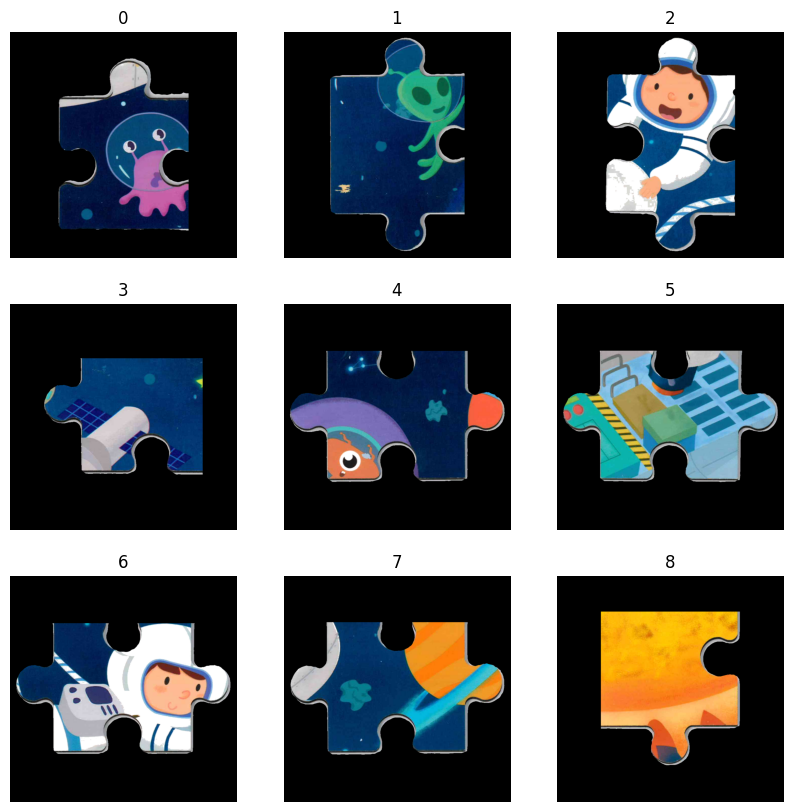

In [11]:
missing1 = np.array(Image.open(data_dir + 'missing-pieces-1.jpg').convert('RGB'))
THICKNESS_CROPPED = 20


ref = np.array([255, 255, 255])
white = 3 * np.square(255) - np.sum(np.square(missing1 - ref),axis=2)
condition = white > np.max(white)*0.98
missing1[condition] = 255


gray = cv2.cvtColor(missing1, cv2.COLOR_RGB2GRAY)
# gray= cv2.GaussianBlur(gray,(7,7),2)
ret,th3 = cv2.threshold(gray,240,255,cv2.THRESH_BINARY_INV)
th3= cv2.GaussianBlur(th3,(7,7),2)
# showpic(th3)


contours,_ = cv2.findContours(th3,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
sorting = sorted([[cnt.shape[0],i]for i,cnt in enumerate(contours)],reverse=True)[:9]
biggest_2 = [contours[s[1]] for s in sorting]
fill_2 = cv2.drawContours(np.zeros(missing1.shape[:2],'uint8'),biggest_2,-1,1,cv2.FILLED)
# showpic(fill_2)

smooth = filters.median_filter(fill_2.astype('uint8'), size=10)
trim_contours, _ = cv2.findContours(smooth, 0, 1)
smooth = cv2.drawContours(np.zeros(smooth.shape[:2]), trim_contours, -1, 1, thickness=cv2.FILLED)
# showpic(smooth)

edges= cv2.drawContours(np.zeros(smooth.shape[:2]), trim_contours, -1, (255,255,255), thickness=THICKNESS_CROPPED)
test = cv2.drawContours(missing1.copy(),trim_contours,-1,(0,255,0),THICKNESS_CROPPED)
# showpic(edges)
# showpic(test)
indexes = np.where(edges == 255)
smooth[indexes] = 0


# Split into tiles
tiles1, tile_centers1,tiles_white1 = [], [], []
contours_tiles, _ = cv2.findContours(smooth.astype(np.uint8), 0, 1)
for i in range(len(contours_tiles)):
  x, y, w, h = cv2.boundingRect(contours_tiles[i])
  shape, tile,tile_white = np.zeros(missing1.shape[:2]), np.zeros((900,900,3), 'uint8'),np.zeros((900,900), 'uint8')
  cv2.drawContours(shape, [contours_tiles[i]], -1, color=1, thickness=-1)
  shape_tile = (missing1 * shape[:,:,None])[y:y+h,x:x+w,:]
  tile[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_tile
  tiles1.append(tile)
  tile_centers1.append((h//2+y, w//2+x))
  shape_white_tile = (smooth * shape[:,:])[y:y+h,x:x+w]
  tile_white[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_white_tile
  tiles_white1.append(tile_white)



tiles1_data = []
# locks identification
for i,tile in  enumerate(tiles_white1):
        cnt, _ = cv2.findContours(tile, 0, 1)
        cnt = cnt[0]
        hull = cv2.convexHull(cnt,returnPoints=False)
        defects = cv2.convexityDefects(cnt,hull)
        moment = cv2.moments(cnt)
        centerx = int(moment['m10'] / moment['m00'])
        centery = int(moment['m01'] / moment['m00'])
        defect_points = []
        # cv2.circle(tiles1[i],[centerx,centery],5,[0,0,255],20)
        for j in range(defects.shape[0]):
            s,e,f,d = defects[j,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if d > 2000:
                # cv2.circle(tiles1[i],far,5,[0,0,255],20)
                defect_points.append(f)
        # print("Puzzle :",i)
        lock = inner_out_lock_orientations(cnt,defect_points,[centerx,centery],tiles1[i])
        tiles1_data.append(lock)
showlist(tiles1,col=3)
# showlist(tiles_white1)  


# Extracting Partial Complete Pieces
Process:
* Maximizing Grey Pixel to white
* Blurring and Thresholding
* Pieces Extraction and Data Packaging

/var/folders/8r/7rhpzt7n08d24pwrzj7xcj7c0000gn/T/ipykernel_15164/4147639964.py:24: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_missing = filters.median_filter(fill.astype('uint8'), size=10)


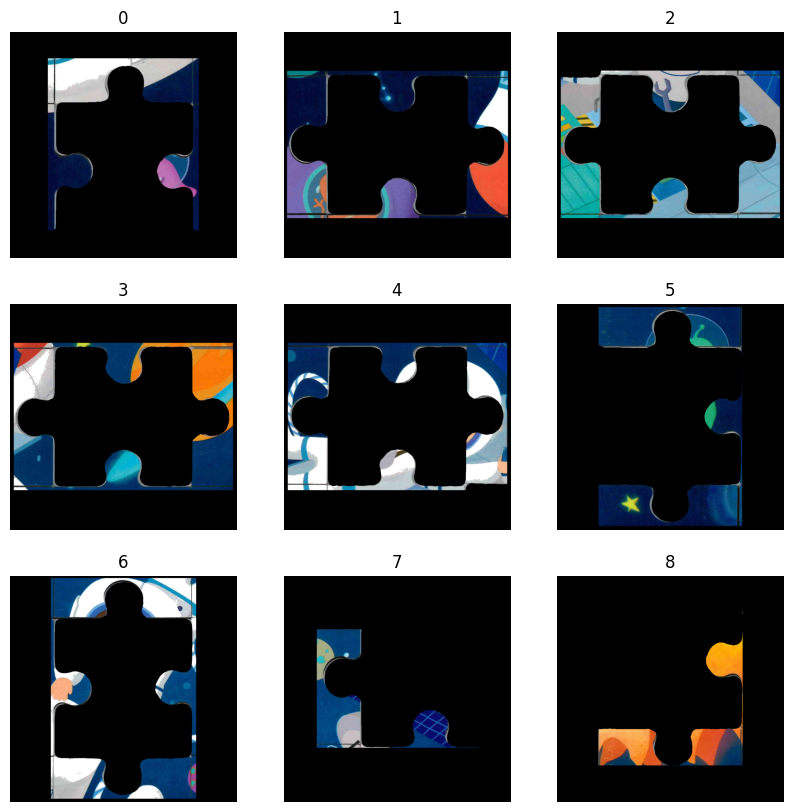

In [12]:
THICKNESS_CROPPED = 25
#missing puzzles
im_missing = np.array(Image.open(data_dir + 'partially-complete.jpg').convert('RGB'))
image = im_missing.copy()
image2 = im_missing.copy()
#maximize white color
ref = np.array([255, 255, 255])
white = 3 * np.square(255) - np.sum(np.square(image - ref),axis=2)
condition = white > np.max(white)*0.973
image[condition] = 255

img = cv2.GaussianBlur(image,(7,7),1)
im_missing_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, thresh_missing =  cv2.threshold(im_missing_gray,245,255,cv2.THRESH_BINARY)
thresh_missing = cv2.GaussianBlur(thresh_missing, (3,3), 1)
# showpic(thresh_missing)

all_missing_puzzle_contours,_ = cv2.findContours(thresh_missing,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorting = sorted([[cnt.shape[0],i]for i,cnt in enumerate(all_missing_puzzle_contours)],reverse=True)[:9]
biggest_missing = [all_missing_puzzle_contours[s[1]] for s in sorting] 
fill = cv2.drawContours(np.zeros(im_missing.shape[:2]),biggest_missing,-1,1,thickness=cv2.FILLED)
# showpic(fill)

smooth_missing = filters.median_filter(fill.astype('uint8'), size=10)
trim_contours, _ = cv2.findContours(smooth_missing, 0, 1)


edges= cv2.drawContours(np.zeros(smooth_missing.shape[:2]), trim_contours, -1, 1, thickness=THICKNESS_CROPPED)
smooth_missing = cv2.drawContours(np.zeros(smooth_missing.shape[:2]), trim_contours, -1, 1, thickness=cv2.FILLED)
# showpic(smooth_missing)
test = cv2.drawContours(image.copy(),trim_contours,-1,(0,255,0),THICKNESS_CROPPED)
# showpic(edges)
smooth_missing =  cv2.bitwise_or(smooth_missing,edges)
# showpic(smooth_missing)

empty_tiles, empty_tile_centers, empty_tile_whites = [], [],[]
contours_empty_tiles, _ = cv2.findContours(smooth_missing.astype(np.uint8), 0, 1)
cv2.drawContours(image, contours_empty_tiles, -1, color=1, thickness=cv2.FILLED)
for i in range(len(contours_empty_tiles)):
        x, y, w, h = cv2.boundingRect(contours_empty_tiles[i])
        tile,tile_white =  np.zeros((900,900,3), 'uint8'),np.zeros((900,900), 'uint8')
        h = h + 30
        y = y - 15
        w = w + 30
        x = x - 15
        if y <0:
                y = y + 15
                h = h - 30
        if y+h > image.shape[0]:
                d = (y +h) - image.shape[0]
                h = h -d
                y = y -d
        if x <0:
                x = x + 15
                w = w - 30
        if x+w > image.shape[1]:
                d = (x+w) - image.shape[1]
                w = w - d
                x = x - d   
        tile[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]= image[y:y+h,x:x+w,:]
        tile_white[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w] = smooth_missing[y:y+h,x:x+w]
        empty_tiles.append(tile)
        empty_tile_centers.append((h//2+y, w//2+x))
        empty_tile_whites.append(tile_white)
        

empty_tiles_data = []
# locks identification
for i,tile in  enumerate(empty_tile_whites):
        cnt, _ = cv2.findContours(tile, 0, 1)
        sorting = sorted([[cnt.shape[0],i]for i,cnt in enumerate(cnt)],reverse=True)[:1]
        biggest = [cnt[s[1]] for s in sorting]
        cnt = biggest[0] 
        hull = cv2.convexHull(cnt,returnPoints=False)
        defects = cv2.convexityDefects(cnt,hull)
        moment = cv2.moments(cnt)
        centerx = int(moment['m10'] / moment['m00'])
        centery = int(moment['m01'] / moment['m00'])
        defect_points = []
        # cv2.circle(empty_tiles[i],[centerx,centery],5,[0,0,255],20)
        for j in range(defects.shape[0]):
            s,e,f,d = defects[j,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if d > 2000:
                # cv2.circle(empty_tiles[i],far,5,[0,0,255],20)
                defect_points.append(f)
        # print("Puzzle :",i)
        lock = inner_out_lock_orientations(cnt,defect_points,[centerx,centery],empty_tiles[i])
        empty_tiles_data.append(lock)  

showlist(empty_tiles,col=3)
# showlist(empty_tile_whites)

# Match and Assemble Missing Pieces 1 and Empty Pieces
Process:
* Shape Matching 
* Color matching
* Image summation
* Replace Empty Pieces

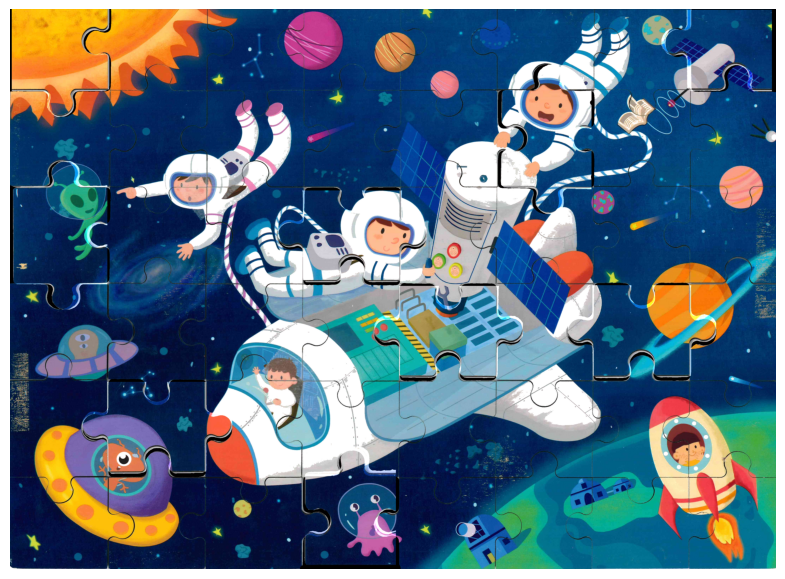

In [4]:
#Matching missing puzzle 1 and empty puzzles

for i,tile in  enumerate(tiles_white1):
    condition = {}
    for data in  tiles1_data[i]:
        condition[dict(data).get('pos')] = dict(data).get('type')
    cmatch_list = []
    index_list = []               
    for j,empty_tile in enumerate(empty_tile_whites):
        candidate_condition = {}
        for data in empty_tiles_data[j]:
            candidate_condition[dict(data).get('pos')] = dict(data).get('type')
            
        # same shape
        if condition == candidate_condition:
            #same color
            sum_cmatch = 0
            for dataA in tiles1_data[i]:
                dataA = dict(dataA)
                for dataB in empty_tiles_data[j]:
                    dataB = dict(dataB)
                    if dataA.get('pos') == dataB.get('pos'):
                        colorA = dataA.get('colour')
                        colorB = dataB.get('colour')
                        cmatch = match_color(tiles1[i].copy(),empty_tiles[j].copy(),colorA,colorB,dataB.get('pos'))
                        # print(dataA.get('pos'),cmatch)
                        sum_cmatch = cmatch + sum_cmatch
            cmatch_list.append(np.round(sum_cmatch / len(tiles1_data[i]),4))
            index_list.append(j)
    index = np.argmin(cmatch_list)
    sum_pic = cv2.add(tiles1[i], empty_tiles[index_list[index]])
    x, y, w, h = cv2.boundingRect(contours_empty_tiles[index_list[index]])
    center = empty_tile_centers[index_list[index]]
    image[center[0]-h//2:center[0]+h//2,center[1]-w//2:center[1]+w//2,:] = sum_pic[450-h//2:450+h//2,450-w//2:450+w//2,:]
showpic(image)


# Extracting Missing Pieces 2
Process:
* Maximizing Grey Pixel to white
* Blurring and Thresholding
* Aligning Puzzles in the Upright Position
* Pieces Extraction and Data Packaging

/var/folders/8r/7rhpzt7n08d24pwrzj7xcj7c0000gn/T/ipykernel_15164/3090367782.py:23: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth = filters.median_filter(fill.astype('uint8'), size=10)


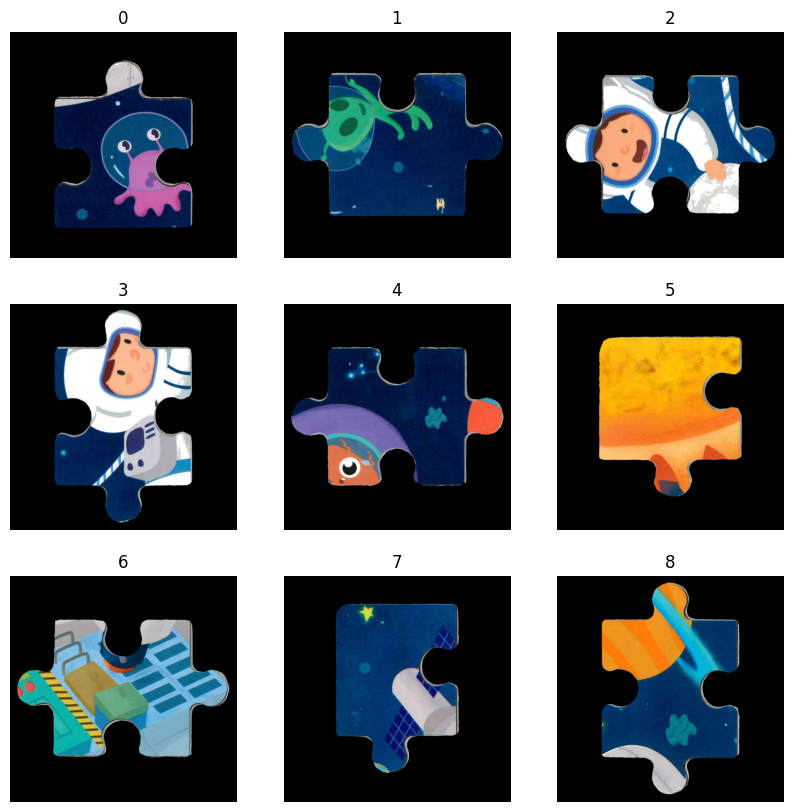

In [5]:
missing2 = np.array(Image.open(data_dir + 'missing-pieces-2.jpg').convert('RGB'))

THICKNESS_CROPPED = 30

ref = np.array([255, 255, 255])
white = 3 * np.square(255) - np.sum(np.square(missing2 - ref),axis=2)
condition = white > np.max(white)*0.98
missing2[condition] = 255

gray = cv2.cvtColor(missing2, cv2.COLOR_RGB2GRAY)
gray= cv2.GaussianBlur(gray,(7,7),2)
ret,th2 = cv2.threshold(gray,240,255,cv2.THRESH_BINARY_INV)
th2= cv2.GaussianBlur(th2,(7,7),2)

# Detect contours
contours, hierarchy = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorting = sorted([[cnt.shape[0],i]for i,cnt in enumerate(contours)],reverse=True)[:9]
biggest = [contours[s[1]] for s in sorting]
fill = cv2.drawContours(np.zeros(th2.shape[:2]),biggest,-1,1,thickness=cv2.FILLED)
# showpic(fill)

# Smooth contours and trim shadows
smooth = filters.median_filter(fill.astype('uint8'), size=10)
trim_contours, _ = cv2.findContours(smooth, 0, 1)
cv2.drawContours(smooth, trim_contours, -1, color=0, thickness=1)
edges= cv2.drawContours(np.zeros(smooth.shape[:2]), trim_contours, -1, (255,255,255), thickness=THICKNESS_CROPPED)
test = cv2.drawContours(missing2.copy(),trim_contours,-1,(0,255,0),THICKNESS_CROPPED)
# showpic(edges)
# showpic(test)
indexes = np.where(edges == 255)
smooth[indexes] = 0


tiles2, tile_centers2,tiles_white2 = [], [], []
contours_tiles, _ = cv2.findContours(smooth, 0, 1)
for i in range(len(contours_tiles)):
  center, (h,w), theta = cv2.minAreaRect(contours_tiles[i])

  x, y, w, h = cv2.boundingRect(contours_tiles[i])
  shape, tile,tile_white = np.zeros(missing2.shape[:2]), np.zeros((900,900,3), 'uint8'),np.zeros((900,900), 'uint8')
  cv2.drawContours(shape, [contours_tiles[i]], -1, color=1, thickness=-1)
  shape_tile = (missing2 * shape[:,:,None])[y:y+h,x:x+w,:]
  tile[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_tile
  shape_white_tile = (smooth * shape[:,:])[y:y+h,x:x+w]
  tile_white[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_white_tile
  rotated_tile = np.array(Image.fromarray(tile.copy()).rotate(theta))
  rotated_white_tile = np.array(Image.fromarray(tile_white.copy()).rotate(theta))
  tile,tile_white,center,a,b = centerPuzzle(rotated_tile,rotated_white_tile)
  tiles2.append(tile)
  tile_centers2.append(center)
  tiles_white2.append(tile_white)



showlist(tiles2,col=3)
# showlist(tiles_white2)

# Match and Assemble Missing Pieces 2 and Empty Pieces
* Create four rotated quadrilateral angle image for each pieces. 
* Shape Matching 
* Color matching
* Image summation
* Replace Empty Pieces

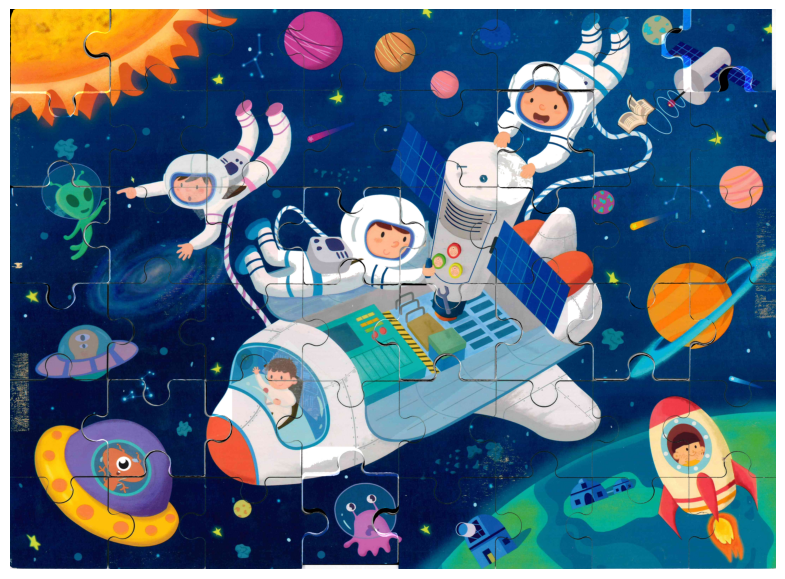

In [6]:
#Matching missing puzzle 2 and empty puzzles
for i,empty_tile in enumerate(empty_tiles):
    # if i ==4:
        condition = {}
        for data in empty_tiles_data[i]:
            condition[dict(data).get('pos')] = dict(data).get('type')
        all_cmatch = []
        all_puzzle = []

        for j,tile in enumerate(tiles2):
            all_rotated_puzzle,all_rotated_white,all_rotated_data  = rotate_puzzle(tile,tiles_white2[j])
            for k,version in enumerate(all_rotated_data):
                candidate_condition = {}
                for segment in version:
                    candidate_condition[dict(segment).get('pos')] = dict(segment).get('type')
                if condition == candidate_condition :
                    cmatch_list = []
                    for dataA in empty_tiles_data[i]:
                        dataA = dict(dataA)
                        for dataB in version:
                            dataB = dict(dataB)
                            if dataA.get('pos') == dataB.get('pos'):
                                colorA = dataA.get('colour')
                                colorB = dataB.get('colour')
                                cmatch = match_color(empty_tile.copy(),all_rotated_puzzle[k].copy(),colorA,colorB,dataB.get('pos'))
                                cmatch_list.append(cmatch)
                    all_cmatch.append(np.mean(cmatch_list))
                    all_puzzle.append(all_rotated_puzzle[k])
        index = np.argmin(all_cmatch)
        # showlist([empty_tile.copy(),all_puzzle[index]],col=2)
        sum_pic = cv2.add(empty_tile,all_puzzle[index])
        x, y, w, h = cv2.boundingRect(contours_empty_tiles[i])
        center = empty_tile_centers[i]
        image2[center[0]-h//2:center[0]+h//2,center[1]-w//2:center[1]+w//2,:] = sum_pic[450-h//2:450+h//2,450-w//2:450+w//2,:]
showpic(image2)


